In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,roc_curve

# Hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import featuretools as ft

In [2]:
# Some hyperparameters
SEED = 20221113
VALID_SIZE = 0.2

In [6]:
def data_process(df):
    
    df.drop_duplicates(inplace=True)

    describe = df.iloc[:,1:].describe([0.01, 0.10, 0.25, 0.50, 0.75, 0.90, 0.99]).T    
    df.MonthlyIncome.fillna(value=df.loc[df.MonthlyIncome<describe.loc['MonthlyIncome','99%']].median(), inplace=True)
    df=df.dropna()
    for i in describe.index:
        df = df[df[i]<describe.loc[i,'99%']]
    
    df['AllNumlate']=df['NumberOfTime30-59DaysPastDueNotWorse']+df['NumberOfTime60-89DaysPastDueNotWorse']+df['NumberOfTimes90DaysLate']
    df['Monthlypayment']=df['DebtRatio']*df['MonthlyIncome']
    df = df.drop(['NumberOfDependents','Monthlypayment',
               'NumberOfTime30-59DaysPastDueNotWorse'],axis=1)
    
    return df

In [7]:
# delet 0 age data 
def process_data(df):
    df.age.value_counts()
    df.drop(df[df.age==0].index,inplace=True)
    df.loc[df['NumberOfTime30-59DaysPastDueNotWorse']>20,'NumberOfTime30-59DaysPastDueNotWorse'] = df.loc[df['NumberOfTime30-59DaysPastDueNotWorse']>20,'NumberOfTime30-59DaysPastDueNotWorse']/5
    df.loc[df['NumberOfTime60-89DaysPastDueNotWorse']>20,'NumberOfTime60-89DaysPastDueNotWorse'] = df.loc[df['NumberOfTime60-89DaysPastDueNotWorse']>20,'NumberOfTime60-89DaysPastDueNotWorse']/5
    df.loc[df['NumberOfTimes90DaysLate']>20,'NumberOfTimes90DaysLate'] = df.loc[df['NumberOfTimes90DaysLate']>20,'NumberOfTimes90DaysLate']/5
    df['NumberOfDependents'].fillna(df['NumberOfDependents'].dropna().median(),inplace = True)
    df.reset_index(drop=True, inplace=True)

    df['agegroup'] = '20-30'
    df.loc[df['age']>30,'agegroup'] = '31-60'
    df.loc[df['age']>60,'agegroup'] = '>60'

    income1,income2,income3 = df[['agegroup','MonthlyIncome']].groupby('agegroup').median().values
    df.loc[df['agegroup']=='20-30','MonthlyIncome'].fillna(income1[0])
    df.loc[df['agegroup']=='31-60','MonthlyIncome'].fillna(income2[0])
    df.loc[df['agegroup']=='>60','MonthlyIncome'].fillna(income3[0])
    df.drop('agegroup',axis=1,inplace=True)
    return df

In [8]:
# Scoring functions

def xgb_score(params):
    print("Training with params: ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    gbm_model = xgb.train(params, dtrain, num_round,
                          evals=watchlist,
                          verbose_eval=False)
    predictions = gbm_model.predict(dvalid,
                                    ntree_limit=gbm_model.best_iteration + 1)
    score = roc_auc_score(y_valid, predictions)
    # TODO: Add the importance for the selected features
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    
    return {'loss': loss, 'status': STATUS_OK}


In [9]:
# Optimization functions

def xgb_optimize(
             num, 
             random_state=SEED):
    """
    This is the optimization function that given a space (space here) of 
    hyperparameters and a scoring function (score here), finds the best hyperparameters.
    """
    space = {
        'n_estimators': hp.quniform('n_estimators', 200, 1000, 1),
        'eta': hp.quniform('eta', 0.01, 0.5, 0.025),
        'max_delta_step': hp.quniform('max_delta_step',1,3,0.25),
        'max_depth':  hp.choice('max_depth', np.arange(2, 12, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
        'subsample': hp.quniform('subsample', 0.5,  1, 0.05),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.05),
        'eval_metric': 'auc',
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'tree_method': 'exact',
        'seed': random_state
    }

    best = fmin(xgb_score, space, algo=tpe.suggest, 
                max_evals=num)
    return best

In [10]:
def makenewvariables(df):
    df.reset_index(drop=True, inplace=True)
    es = ft.EntitySet(id = 'credit')
    es.add_dataframe(dataframe_name = 'data', dataframe = df,index="index")

    feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                          trans_primitives = ['add_numeric', 'multiply_numeric'])
    return feature_matrix

In [28]:
def xgb_test(params):
    colsample_bytree, eta, gamma,max_delta_step, max_depth, min_child_weight,n_estimators,subsample = params.values()
    gbm_model = xgb.XGBRegressor(colsample_bytree=colsample_bytree,eta=eta,gamma=gamma,max_delta_step = max_delta_step,
                             max_depth=int(max_depth), min_child_weight=int(min_child_weight), 
                             n_estimators=int(n_estimators), subsample=subsample)

    gbm_model.fit(x_train,y_train)
    preds = gbm_model.predict(x_valid)
    score = roc_auc_score(y_valid, preds)

    fpr, tpr, thresh_lr = roc_curve(y_valid,preds)
    plot_roc_curve(fpr,tpr)
    print("AUC = {}".format(roc_auc_score(y_valid,preds)))

    print('KS = {}'.format((tpr-fpr).max(),2),2)
    print(f'The ACU is: {score}')
    
    test = pd.read_csv('data/cs-test.csv',index_col=0)
    x_test = test.iloc[:,1:]
    x_test = process_data(x_test)
    x_test = makenewvariables(x_test)
    test_preds = gbm_model.predict(x_test)
    submission = pd.DataFrame({'Id':test.index, 'Probability': test_preds})
    submission.loc[submission['Probability']<0,'Probability'] = 0
    submission.loc[submission['Probability']>1,'Probability'] = 1
    submission.to_csv('xgb_submission.csv', index=False)
    
    

In [20]:
def plot_roc_curve(fpr,tpr):
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], "k--")
    plt.xlabel('FPR')
    plt.ylabel('TPR')


In [17]:
# Load processed data

test = pd.read_csv('data/cs-test.csv',index_col=0)
data = pd.read_csv('data/cs-training.csv',index_col=0)

train_df = process_data(data)
train_df = pd.concat((train_df.iloc[:,0],makenewvariables(train_df.iloc[:,1:])),axis=1)

train, valid = train_test_split(train_df, test_size=VALID_SIZE,
                                random_state=SEED)

x_train = train.iloc[:,1:]
x_valid = valid.iloc[:,1:]
y_train = train.iloc[:,0]
y_valid = valid.iloc[:,0]

print('The training set is of length: ', len(train.index))
print('The validation set is of length: ', len(valid.index))


xgb_best_hyperparams = xgb_optimize(num = 10)
print("The best hyperparameters are: ", "\n")
print(xgb_best_hyperparams)

C:\Users\shenl\anaconda3\lib\site-packages\featuretools\entityset\entityset.py:1867: UserWarning: index index not found in dataframe, creating new integer column
  "integer column".format(index)
C:\Users\shenl\anaconda3\lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:162: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  "Only one dataframe in entityset, changing max_depth to "


The training set is of length:  119999
The validation set is of length:  30000
Training with params:                                                                                                  
{'booster': 'gbtree', 'colsample_bytree': 0.55, 'eta': 0.1, 'eval_metric': 'auc', 'gamma': 0.65, 'max_delta_step': 3.0, 'max_depth': 11, 'min_child_weight': 4.0, 'n_estimators': 617.0, 'objective': 'binary:logistic', 'seed': 20221113, 'subsample': 1.0, 'tree_method': 'exact'}
	Score 0.8525958613159796                                                                                              


Training with params:                                                                                                  
{'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.325, 'eval_metric': 'auc', 'gamma': 0.9500000000000001, 'max_delta_step': 2.5, 'max_depth': 6, 'min_child_weight': 9.0, 'n_estimators': 926.0, 'objective': 'binary:logistic', 'seed': 20221113, 'subsample': 0.9, 'tree_method': 

C:\Users\shenl\anaconda3\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



	Score 0.8251967810131571                                                                                              


Training with params:                                                                                                  
{'booster': 'gbtree', 'colsample_bytree': 0.35000000000000003, 'eta': 0.325, 'eval_metric': 'auc', 'gamma': 0.55, 'max_delta_step': 2.0, 'max_depth': 3, 'min_child_weight': 3.0, 'n_estimators': 559.0, 'objective': 'binary:logistic', 'seed': 20221113, 'subsample': 0.8, 'tree_method': 'exact'}
 20%|█████████▍                                     | 2/10 [05:09<20:56, 157.03s/trial, best loss: 0.14740413868402036]

C:\Users\shenl\anaconda3\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



	Score 0.8622886001319381                                                                                              


Training with params:                                                                                                  
{'booster': 'gbtree', 'colsample_bytree': 0.25, 'eta': 0.325, 'eval_metric': 'auc', 'gamma': 0.8, 'max_delta_step': 2.0, 'max_depth': 4, 'min_child_weight': 9.0, 'n_estimators': 732.0, 'objective': 'binary:logistic', 'seed': 20221113, 'subsample': 0.9, 'tree_method': 'exact'}
 30%|██████████████▍                                 | 3/10 [05:52<12:14, 104.93s/trial, best loss: 0.1377113998680619]

C:\Users\shenl\anaconda3\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



	Score 0.8497606794925956                                                                                              


Training with params:                                                                                                  
{'booster': 'gbtree', 'colsample_bytree': 0.8, 'eta': 0.25, 'eval_metric': 'auc', 'gamma': 0.6000000000000001, 'max_delta_step': 1.25, 'max_depth': 10, 'min_child_weight': 8.0, 'n_estimators': 577.0, 'objective': 'binary:logistic', 'seed': 20221113, 'subsample': 0.8, 'tree_method': 'exact'}
 40%|███████████████████▌                             | 4/10 [06:50<08:39, 86.62s/trial, best loss: 0.1377113998680619]

C:\Users\shenl\anaconda3\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



	Score 0.8243400038543509                                                                                              


Training with params:                                                                                                  
{'booster': 'gbtree', 'colsample_bytree': 0.75, 'eta': 0.225, 'eval_metric': 'auc', 'gamma': 0.7000000000000001, 'max_delta_step': 2.5, 'max_depth': 5, 'min_child_weight': 2.0, 'n_estimators': 318.0, 'objective': 'binary:logistic', 'seed': 20221113, 'subsample': 0.6000000000000001, 'tree_method': 'exact'}
 50%|████████████████████████                        | 5/10 [09:11<08:50, 106.01s/trial, best loss: 0.1377113998680619]

C:\Users\shenl\anaconda3\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



	Score 0.8547279018503774                                                                                              


Training with params:                                                                                                  
{'booster': 'gbtree', 'colsample_bytree': 0.45, 'eta': 0.025, 'eval_metric': 'auc', 'gamma': 0.8500000000000001, 'max_delta_step': 1.25, 'max_depth': 7, 'min_child_weight': 4.0, 'n_estimators': 677.0, 'objective': 'binary:logistic', 'seed': 20221113, 'subsample': 0.8, 'tree_method': 'exact'}
 60%|█████████████████████████████▍                   | 6/10 [09:53<05:38, 84.54s/trial, best loss: 0.1377113998680619]

C:\Users\shenl\anaconda3\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



	Score 0.873910885035188                                                                                               


Training with params:                                                                                                  
{'booster': 'gbtree', 'colsample_bytree': 0.45, 'eta': 0.275, 'eval_metric': 'auc', 'gamma': 0.9, 'max_delta_step': 1.75, 'max_depth': 7, 'min_child_weight': 7.0, 'n_estimators': 564.0, 'objective': 'binary:logistic', 'seed': 20221113, 'subsample': 0.9500000000000001, 'tree_method': 'exact'}
 70%|███████████████████████████████████               | 7/10 [11:27<04:22, 87.62s/trial, best loss: 0.126089114964812]

C:\Users\shenl\anaconda3\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



	Score 0.8389717331283771                                                                                              


Training with params:                                                                                                  
{'booster': 'gbtree', 'colsample_bytree': 0.15000000000000002, 'eta': 0.2, 'eval_metric': 'auc', 'gamma': 0.7000000000000001, 'max_delta_step': 1.25, 'max_depth': 6, 'min_child_weight': 7.0, 'n_estimators': 689.0, 'objective': 'binary:logistic', 'seed': 20221113, 'subsample': 0.5, 'tree_method': 'exact'}
 80%|████████████████████████████████████████          | 8/10 [12:49<02:51, 85.65s/trial, best loss: 0.126089114964812]

C:\Users\shenl\anaconda3\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



	Score 0.8403808189964226                                                                                              


Training with params:                                                                                                  
{'booster': 'gbtree', 'colsample_bytree': 0.4, 'eta': 0.15000000000000002, 'eval_metric': 'auc', 'gamma': 0.55, 'max_delta_step': 2.0, 'max_depth': 9, 'min_child_weight': 3.0, 'n_estimators': 710.0, 'objective': 'binary:logistic', 'seed': 20221113, 'subsample': 0.55, 'tree_method': 'exact'}
 90%|█████████████████████████████████████████████     | 9/10 [13:46<01:16, 76.65s/trial, best loss: 0.126089114964812]

C:\Users\shenl\anaconda3\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



	Score 0.8283296999290819                                                                                              


100%|█████████████████████████████████████████████████| 10/10 [15:37<00:00, 93.73s/trial, best loss: 0.126089114964812]
The best hyperparameters are:  

{'colsample_bytree': 0.45, 'eta': 0.025, 'gamma': 0.8500000000000001, 'max_delta_step': 1.25, 'max_depth': 5, 'min_child_weight': 4.0, 'n_estimators': 677.0, 'subsample': 0.8}


C:\Users\shenl\anaconda3\lib\site-packages\xgboost\core.py:94: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  UserWarning



AUC = 0.8746251010503876
KS = 0.5920341501641855 2
The ACU is: 0.8746251010503876


C:\Users\shenl\anaconda3\lib\site-packages\featuretools\entityset\entityset.py:1867: UserWarning: index index not found in dataframe, creating new integer column
  "integer column".format(index)
C:\Users\shenl\anaconda3\lib\site-packages\featuretools\synthesis\deep_feature_synthesis.py:162: UserWarning: Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created
  "Only one dataframe in entityset, changing max_depth to "


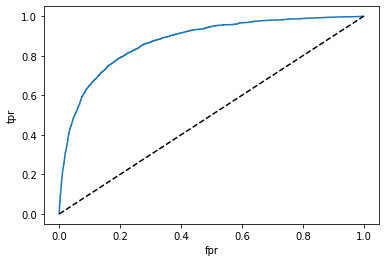

In [29]:
xgb_test(xgb_best_hyperparams)